For this task we used CTU scenario 43 (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import time
from helper_functions.sampling import *

df = pd.read_csv('./data/capture20110811.pcap.netflow.labeled', sep ='\s+')
df.head()

infected_host = '147.32.84.165'

Some preprocessing; separating features `Src_IP_Addr:Port` and `Dst_IP_Addr:Port` into separate features for tuilized IP addresses and ports. Additioanally, discarding of some not-used features (e.g. `->` is discarded as we only considering unidirectional netflows).

In [2]:
df[['Src_IP_Addr', 'Src_Port']] = df['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
df[['Dst_IP_Addr', 'Dst_Port']] = df['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

df['Label'] = df['Label(LEGITIMATE:Botnet:Background)']

df = df.drop(labels=['->', 'Label(LEGITIMATE:Botnet:Background)', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1)

df.head()

,#Date_flow,start,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Label
0,2011-08-11,10:10:00.003,0.967,UDP,INT,0,2,135,1,89.31.8.11,23929,147.32.84.229,13363,Background
1,2011-08-11,10:10:00.003,0.967,UDP,INT,0,2,276,1,147.32.84.229,13363,89.31.8.11,23929,Background
2,2011-08-11,10:10:00.006,0.000,UDP,INT,0,1,62,1,208.88.186.6,34042,147.32.84.229,13363,Background
3,2011-08-11,10:10:00.008,0.000,UDP,INT,0,1,78,1,92.118.218.77,55246,147.32.84.229,13363,Background
4,2011-08-11,10:10:00.009,0.000,UDP,INT,0,1,72,1,182.185.139.181,10223,147.32.84.229,13363,Background


The infected host documented in the dataset (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/) is 147.32.84.165. We want now to examine the hosts, that host connects with; we are thus going to consider netflows where this host appears either as source or destination.

In [3]:
comm_hosts = []

hosts = df[df['Src_IP_Addr']==infected_host]['Dst_IP_Addr'].values
comm_hosts.append(hosts)

hosts = df[df['Dst_IP_Addr']==infected_host]['Src_IP_Addr'].values
comm_hosts.append(hosts)
comm_hosts = [x for sublist in comm_hosts for x in sublist]
total_count = len(comm_hosts)

ground_truth = pd.DataFrame(comm_hosts, columns=['IP_Addr'])
ground_truth = ground_truth.groupby('IP_Addr').size()
ground_truth = ground_truth/total_count
ground_truth = ground_truth.sort_values(ascending=False)
unique_comm_hosts = np.array(ground_truth.index)

ground_truth.head(10)

IP_Addr
193.23.181.44      0.118347
174.128.246.102    0.075340
174.37.196.55      0.068102
173.236.31.226     0.062646
184.154.89.154     0.061433
67.19.72.206       0.059229
46.4.36.120        0.057869
72.20.15.61        0.057153
147.32.80.9        0.028898
212.117.171.138    0.017765
dtype: float64

Here we have an "interactive visualizer". You can adjust `topN` and the counts of the topN most frequent hosts will be visualized. Here we present the distribution for `topN=10`.

Text(0, 0.5, 'Frequency')

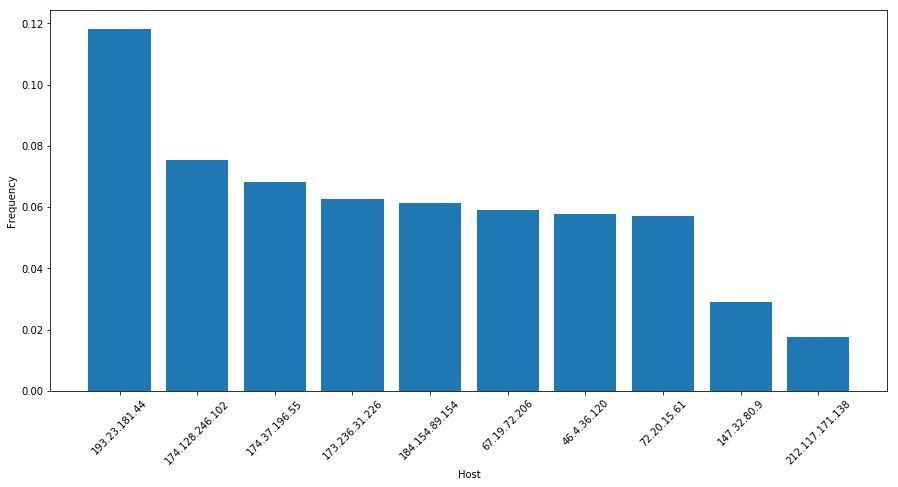

In [4]:
import seaborn as sns

topN=10

plt.figure(figsize=(15,7))
plt.bar(range(topN), ground_truth.head(topN).values)
plt.xticks(range(topN), ground_truth.head(topN).index, rotation=45)

plt.xlabel('Host')
plt.ylabel('Frequency')

In [12]:
df_r = sample(comm_hosts, 10000000)
df_r = pd.DataFrame(data=df_r, columns=['IP_Addr']).groupby('IP_Addr').size()
df_r = df_r.sort_values(ascending=False)
df_r.head(10)

IP_Addr
193.23.181.44      6442
174.128.246.102    4101
174.37.196.55      3707
173.236.31.226     3410
184.154.89.154     3344
67.19.72.206       3224
46.4.36.120        3150
72.20.15.61        3111
147.32.80.9        1573
212.117.171.138     967
dtype: int64

In [15]:
df_r = sample2(comm_hosts, 1000000)
df_r = pd.DataFrame(data=df_r, columns=['IP_Addr']).groupby('IP_Addr').size()
df_r = df_r.sort_values(ascending=False)
df_r.head(10)

IP_Addr
193.23.181.44      6442
174.128.246.102    4101
174.37.196.55      3707
173.236.31.226     3410
184.154.89.154     3344
67.19.72.206       3224
46.4.36.120        3150
72.20.15.61        3111
147.32.80.9        1573
212.117.171.138     967
dtype: int64

Here RESERVOIR sampling is performed for various values of reservoir size `k`. For more information about the used helper functions please refer to `helper_functions/sampling.py`.

Extracted results are stored into dictionaries; for each value of `k` the IPs with the respective frequencies are stored in `dic`, the respective execution time in `dur_dic`. The dictionary `enum` is just an enumeration of the tested combinations, for easier access of the aforementioned dictionaries.

In [5]:
reservoir_sizes = [10,50,100,500,1000,10000,50000,100000]

enum = {}
dic = {}
dur_dic = {}
i=0
for k in reservoir_sizes:
    
    # Start timer 
    start_time = time.time()
    
    res = sample(comm_hosts, k)
    unique_hosts, counts = np.unique(res, return_counts=True)
    counts = counts/np.sum(counts)
    sorted_ind = np.flip(np.argsort(counts))
    
    # Stop timer
    dur = time.time() - start_time
    
    enum[i] = reservoir_sizes[i]
    dic[k] = {'IP_Addr':unique_hosts[sorted_ind], 'Frequency':counts[sorted_ind]}
    dur_dic[k] = dur
    
    i=i+1

Now in order to compare the results we repeat our ground truth here, that is the top-10 IPs with their repsective counts.

In [6]:
ground_truth.head(10)

IP_Addr
193.23.181.44      0.118347
174.128.246.102    0.075340
174.37.196.55      0.068102
173.236.31.226     0.062646
184.154.89.154     0.061433
67.19.72.206       0.059229
46.4.36.120        0.057869
72.20.15.61        0.057153
147.32.80.9        0.028898
212.117.171.138    0.017765
dtype: float64

As expected, for low value of `k` the top-10 is far away from ground-truth!

In [6]:
df = pd.DataFrame(data=dic[enum[0]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
173.236.31.226,0.2
147.32.80.9,0.2
72.20.15.61,0.1
64.12.90.98,0.1
46.4.36.120,0.1
217.163.21.35,0.1
193.23.181.44,0.1
184.154.89.154,0.1


As `k` increases the performed sampling converges to ground-truth.

In [7]:
df = pd.DataFrame(data=dic[enum[5]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
193.23.181.44,0.1177
174.128.246.102,0.0756
174.37.196.55,0.0685
173.236.31.226,0.0650
184.154.89.154,0.0609
67.19.72.206,0.0606
72.20.15.61,0.0578
46.4.36.120,0.0535
147.32.80.9,0.0296


Finally, we see that for the case `k=100000` we got a perfect match for IPs and corresponding frequencies!

In [8]:
df = pd.DataFrame(data=dic[enum[7]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
193.23.181.44,0.118347
174.128.246.102,0.075340
174.37.196.55,0.068102
173.236.31.226,0.062646
184.154.89.154,0.061433
67.19.72.206,0.059229
46.4.36.120,0.057869
72.20.15.61,0.057153
147.32.80.9,0.028898


Here we evaluate the samoling performed for various values of `k`; we extract recall values, that is how many IPs of the top-10 ground-truth are found in the extracted top-10 sampling. Additionally, we compute the divergence of frequencies computed; for each IP of ground-truth top-10 occuring also at the top-10 sampling we compute the absolute difference of the frequencies; in case the IP is missing from the top-10 sampling only the respective ground-truth frequency is added.

For `k=500,1000,10000,50000,100000` all IPs are correctly identified. As `k` increase the frequency distance also decrease and finally for `k=100000` we got a perfect match!

In [9]:
n = len(dic)
rec = np.zeros(n)
dis = np.zeros(n)
for i in range(len(dic)):
    df = pd.DataFrame(data=dic[enum[i]])
    df.set_index('IP_Addr', inplace=True)
    
    rec[i], dis[i] = evaluate(ground_truth.head(10), df.head(10))
    
print("Recall values: ", rec)
print("Divergence: ", dis)

Recall values:  [0.5 0.7 0.7 0.9 0.9 1.  1.  1. ]
Divergence:  [0.70254074 0.31974868 0.27269487 0.1091665  0.09157366 0.01234718
 0.00228298 0.        ]


Finally a visualization for the execution time versus `depth` and `width`. In the following visualization rows correspond to depth values and columns to width values.

Text(0, 0.5, 'Frequency distance')

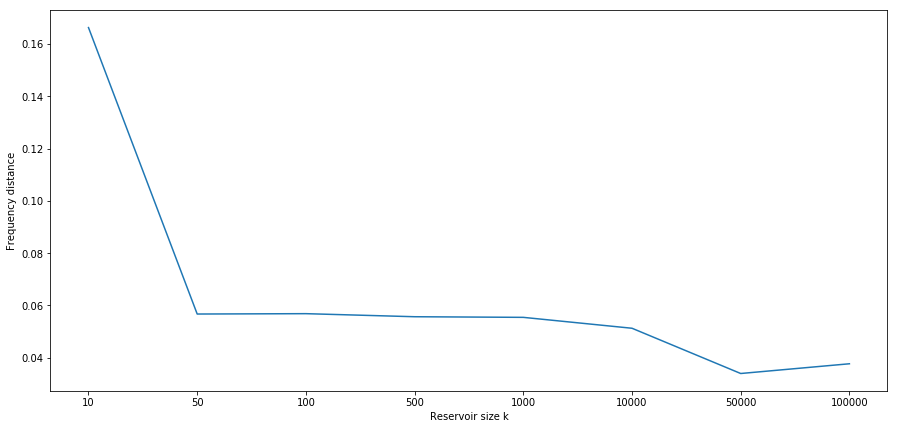

In [10]:
plt.figure(figsize=(15,7))
plt.plot(list(dur_dic.values()))
plt.xticks(range(len(dic)), reservoir_sizes)
plt.xlabel('Reservoir size k')
plt.ylabel('Frequency distance')